In [1]:
import sys

sys.path.append("../")

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from mlresearch.utils import set_matplotlib_style
from algorec.recourse import NFeatureRecourse
from algorec.populations import BasePopulation
from algorec.environments import BankLoanApplication3

In [3]:
set_matplotlib_style(16)

# Some variables to define the problem
RNG_SEED = 42
N_CONTINUOUS = 2
N_CAT = 0
N_AGENTS = 100

# Environment variables
N_LOANS = 10  # np.array([20, 1, 10, 30, 0, 5, 50, 10, 40])
ADAPTATION = 0.5  # np.array([.2, .1, .3, .25, .1, .4, .05, .05, .2])
NEW_AGENTS = 11  # np.array([40, 10, 50, 5, 0, 100, 0, 0, 20])

# TODO: end and stop from updating when population becomes too small

# Generate data and fit regression
continuous = [f"f_{i}" for i in range(N_CONTINUOUS)]
categorical = [f"cat_{i}" for i in range(N_CAT)]
rng = np.random.default_rng(RNG_SEED)
df = pd.DataFrame(
    rng.random((N_AGENTS, N_CONTINUOUS)),
    columns=[f"f_{i}" for i in range(N_CONTINUOUS)],
)

for i in range(N_CAT):
    df[f"cat_{i}"] = rng.integers(0, 2, N_AGENTS)

y = rng.integers(0, 2, N_AGENTS)
lr = LogisticRegression().fit(df, y)

In [4]:
# Define the necessary components to run simulation
population = BasePopulation(df, categorical=categorical)
recourse = NFeatureRecourse(lr, n_features=2)
environment = BankLoanApplication3(
    population,
    recourse,
    n_loans=N_LOANS,
    adaptation=ADAPTATION,
    new_agents=NEW_AGENTS,
    random_state=RNG_SEED,
)

environment.run_simulation(100)

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Population scores over 101 time steps'}, xlabel='Step', ylabel='Score'>)

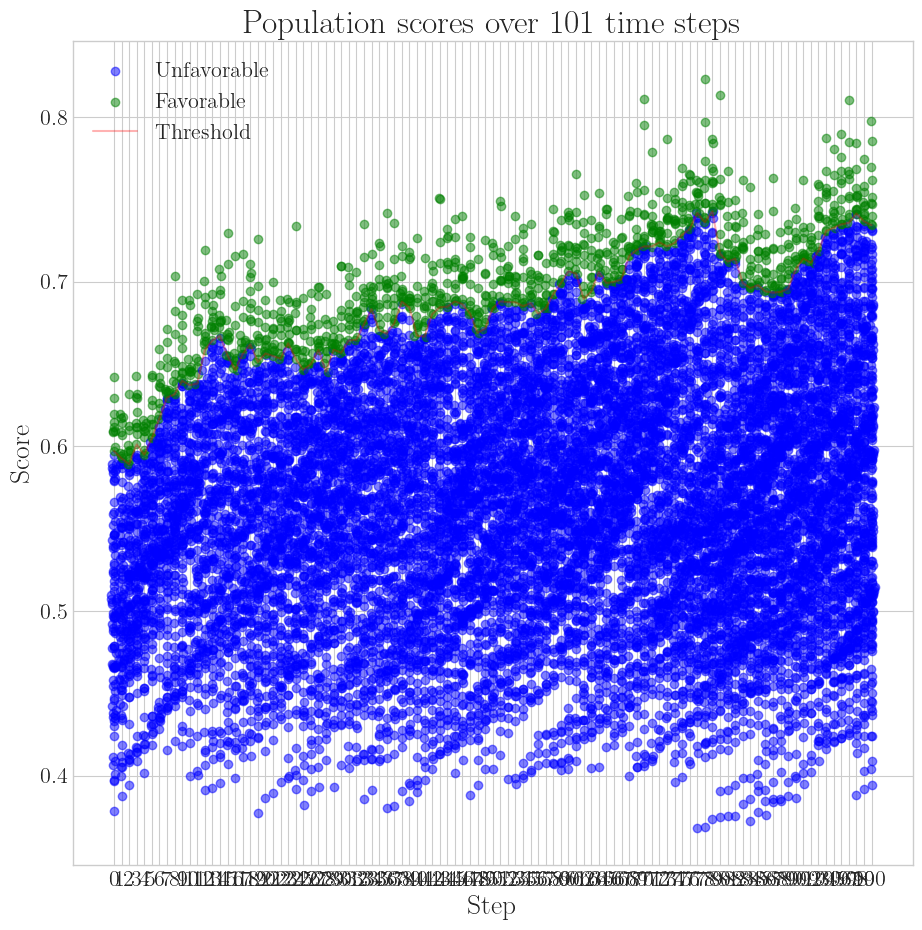

In [17]:
environment.plot.agent_scores()

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Population at t=3'}, xlabel='f_0', ylabel='f_1'>)

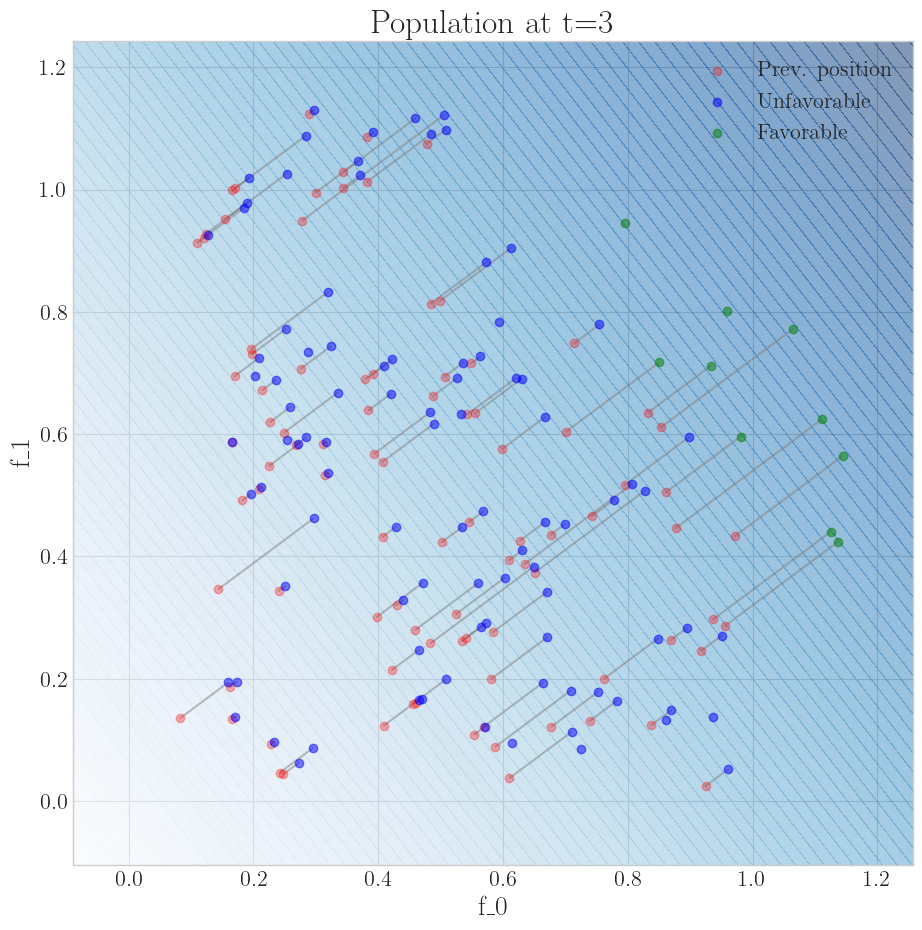

In [6]:
environment.plot.scatter(3)

(array([ 4.,  5., 12., 14., 20., 10., 13., 11.,  8.,  3.]),
 array([0.37874517, 0.40511149, 0.43147781, 0.45784413, 0.48421045,
        0.51057677, 0.53694309, 0.56330941, 0.58967573, 0.61604205,
        0.64240837]),
 <BarContainer object of 10 artists>)

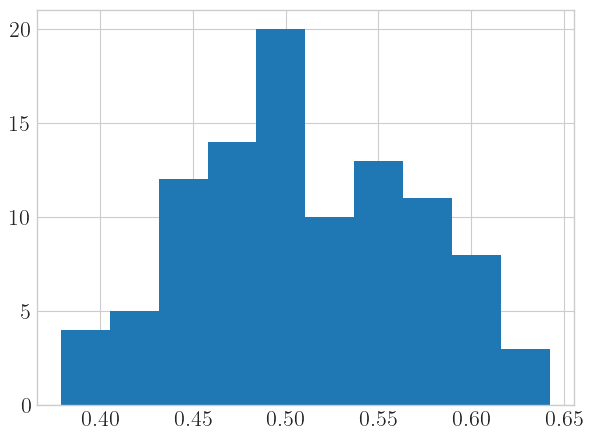

In [7]:
environment.plot.scores_histogram(0)

<Axes: ylabel='Density'>

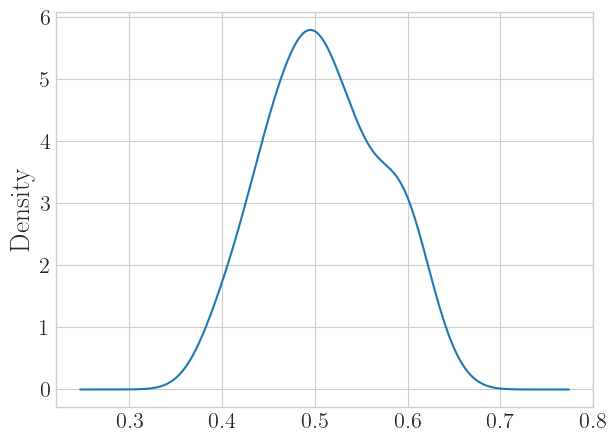

In [8]:
environment.plot.scores_kde(0)
# environment.plot.scores_kde(100)

<Axes: title={'center': 'Population size over 101 time steps'}, xlabel='Step', ylabel='Number of agents'>

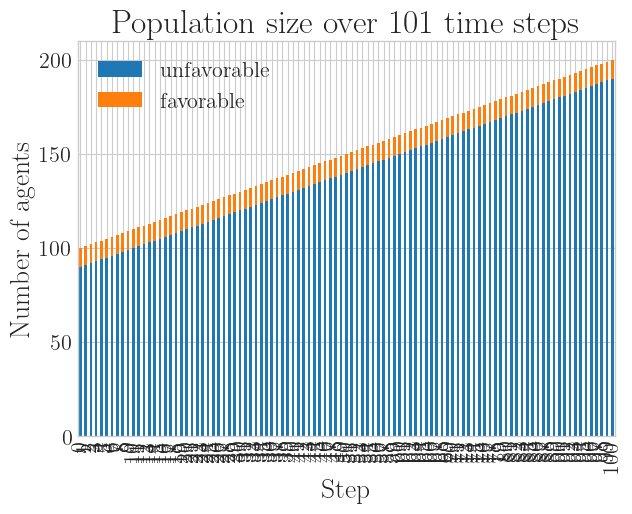

In [9]:
environment.plot.population_size()

In [10]:
environment.success_rate(1, 20)

array([1.        , 1.        , 0.66666667, 1.        , 0.71428571,
       0.6       , 0.52631579, 0.90909091, 0.71428571, 1.        ,
       0.83333333, 0.76923077, 0.76923077, 0.90909091, 1.        ,
       1.        , 0.625     , 0.83333333, 1.        ])

In [11]:
environment.threshold_drift(1, 20)

array([-0.00752553, -0.005935  ,  0.02032878, -0.01028756,  0.01672501,
        0.0197297 ,  0.02071047,  0.00309454,  0.01295865, -0.00406786,
        0.00157096,  0.03198726,  0.00871774,  0.0041709 , -0.01784588,
       -0.01334056,  0.01489779,  0.00894759, -0.01612888,  0.00787184])

In [12]:
steps_info = environment.steps_info()
steps_info.tail(10)

,n_adapted,n_candidates,favorable_outcomes,success_rate,threshold,threshold_drift,new_agents,new_agents_proba,moving_agent_proba,success_proba
91,180.0,12.0,10.0,0.833333,0.714029,0.009025,11.0,0.0,0.061172,0.250261
92,181.0,7.0,10.0,1.000000,0.711475,-0.003577,11.0,0.0,0.096050,0.000637
93,182.0,16.0,10.0,0.625000,0.718741,0.010214,11.0,0.0,0.078046,0.014742
94,183.0,16.0,10.0,0.625000,0.730775,0.016742,11.0,0.0,0.056652,0.326937
95,184.0,10.0,10.0,1.000000,0.732724,0.002666,11.0,0.0,0.050418,0.535435
96,185.0,11.0,10.0,0.909091,0.734824,0.002867,11.0,0.0,0.054916,0.354528
97,186.0,11.0,10.0,0.909091,0.735697,0.001188,11.0,0.0,0.060012,0.194234
98,187.0,11.0,10.0,0.909091,0.741360,0.007697,11.0,0.0,0.046555,0.649037
99,188.0,7.0,10.0,1.000000,0.736688,-0.006301,11.0,0.0,0.056617,0.275860
100,189.0,8.0,10.0,1.000000,0.734285,-0.003263,11.0,0.0,0.045722,0.665345


,success_proba,threshold_drift
success_proba,1.000000,0.747262
threshold_drift,0.747262,1.000000


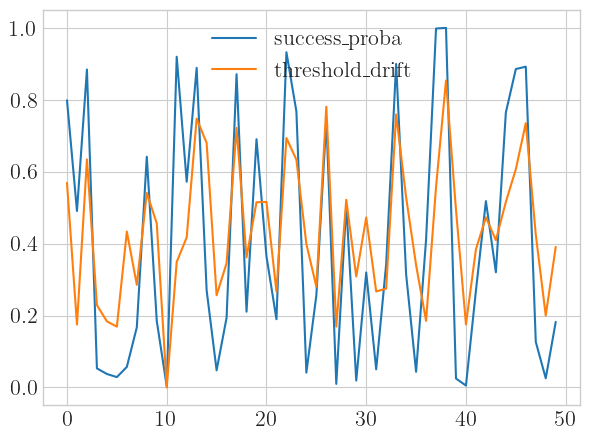

In [19]:
predictions = pd.concat(
    [
        steps_info.success_proba.iloc[:-1].reset_index(drop=True),
        steps_info.threshold_drift.iloc[1:].reset_index(drop=True) * -1,
    ],
    axis=1,
).astype(float)
((predictions - predictions.min()) / (predictions.max() - predictions.min())).iloc[
    :50
].plot.line()
predictions.corr()

In [14]:
steps_info.astype(float).corr().round(2)

,n_adapted,n_candidates,favorable_outcomes,success_rate,threshold,threshold_drift,new_agents,new_agents_proba,moving_agent_proba,success_proba
n_adapted,1.00,0.02,NaN,0.09,0.91,-0.09,NaN,-0.43,-0.64,-0.02
n_candidates,0.02,1.00,NaN,-0.92,0.10,0.86,NaN,-0.09,-0.01,-0.03
favorable_outcomes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
success_rate,0.09,-0.92,NaN,1.00,0.03,-0.77,NaN,-0.02,-0.10,0.07
threshold,0.91,0.10,NaN,0.03,1.00,0.01,NaN,-0.62,-0.72,0.11
threshold_drift,-0.09,0.86,NaN,-0.77,0.01,1.00,NaN,0.01,-0.07,0.16
new_agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
new_agents_proba,-0.43,-0.09,NaN,-0.02,-0.62,0.01,NaN,1.00,0.37,0.01
moving_agent_proba,-0.64,-0.01,NaN,-0.10,-0.72,-0.07,NaN,0.37,1.00,-0.70
success_proba,-0.02,-0.03,NaN,0.07,0.11,0.16,NaN,0.01,-0.70,1.00


In [15]:
environment.agents_info()

,entered_step,n_adaptations,favorable_step,original_score,final_score,n_failures
0,0,3,3.0,0.552311,0.607362,0
1,0,0,0.0,0.599871,0.599871,0
2,0,9,9.0,0.505332,0.645305,2
3,0,1,1.0,0.594853,0.618035,0
4,0,12,12.0,0.442284,0.668922,0
...,...,...,...,...,...,...
1195,100,0,NaN,0.499805,NaN,0
1196,100,0,NaN,0.625242,NaN,0
1197,100,0,NaN,0.515231,NaN,0
1198,100,0,NaN,0.408603,NaN,0
